In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs

base = Path("results/2025-09-21_ResNet/default")

results = []
for csv in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv)
	logs = logs.assign(**meta)  # add metadata to each row
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
	last_epoch.groupby(["arch", "width"])
	.agg(
		test_acc_mean=("test_acc", "mean"),
		test_acc_std=("test_acc", "std"),
		test_loss_mean=("test_loss", "mean"),
		test_loss_std=("test_loss", "std"),
		runs=("seed", "count"),
	)
	.reset_index()
)

# Print nicely
for _, row in agg.iterrows():
	print(
		f"{row.arch}, width={row.width:.3f}: "
		f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
		f"(n={row.runs}), "
		f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
	)


resnet18, width=4.000: Acc=0.780 ± 0.006 (n=2), Loss=0.729 ± 0.009
resnet18, width=12.000: Acc=0.722 ± 0.002 (n=2), Loss=1.306 ± 0.032
resnet18, width=64.000: Acc=0.840 ± nan (n=1), Loss=1.524 ± nan


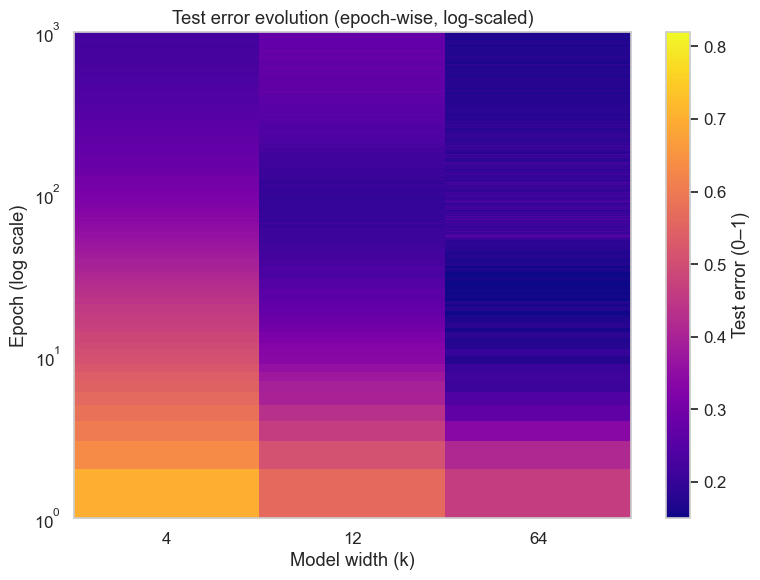

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
	df.groupby(["width", "epoch"], as_index=False)
	.agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [4, 12, 64]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values              # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [4, 12, 64]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.82)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

![WhatsApp Image 2025-09-22 at 15.19.54_ca7aac01.jpg](<attachment:WhatsApp Image 2025-09-22 at 15.19.54_ca7aac01.jpg>)
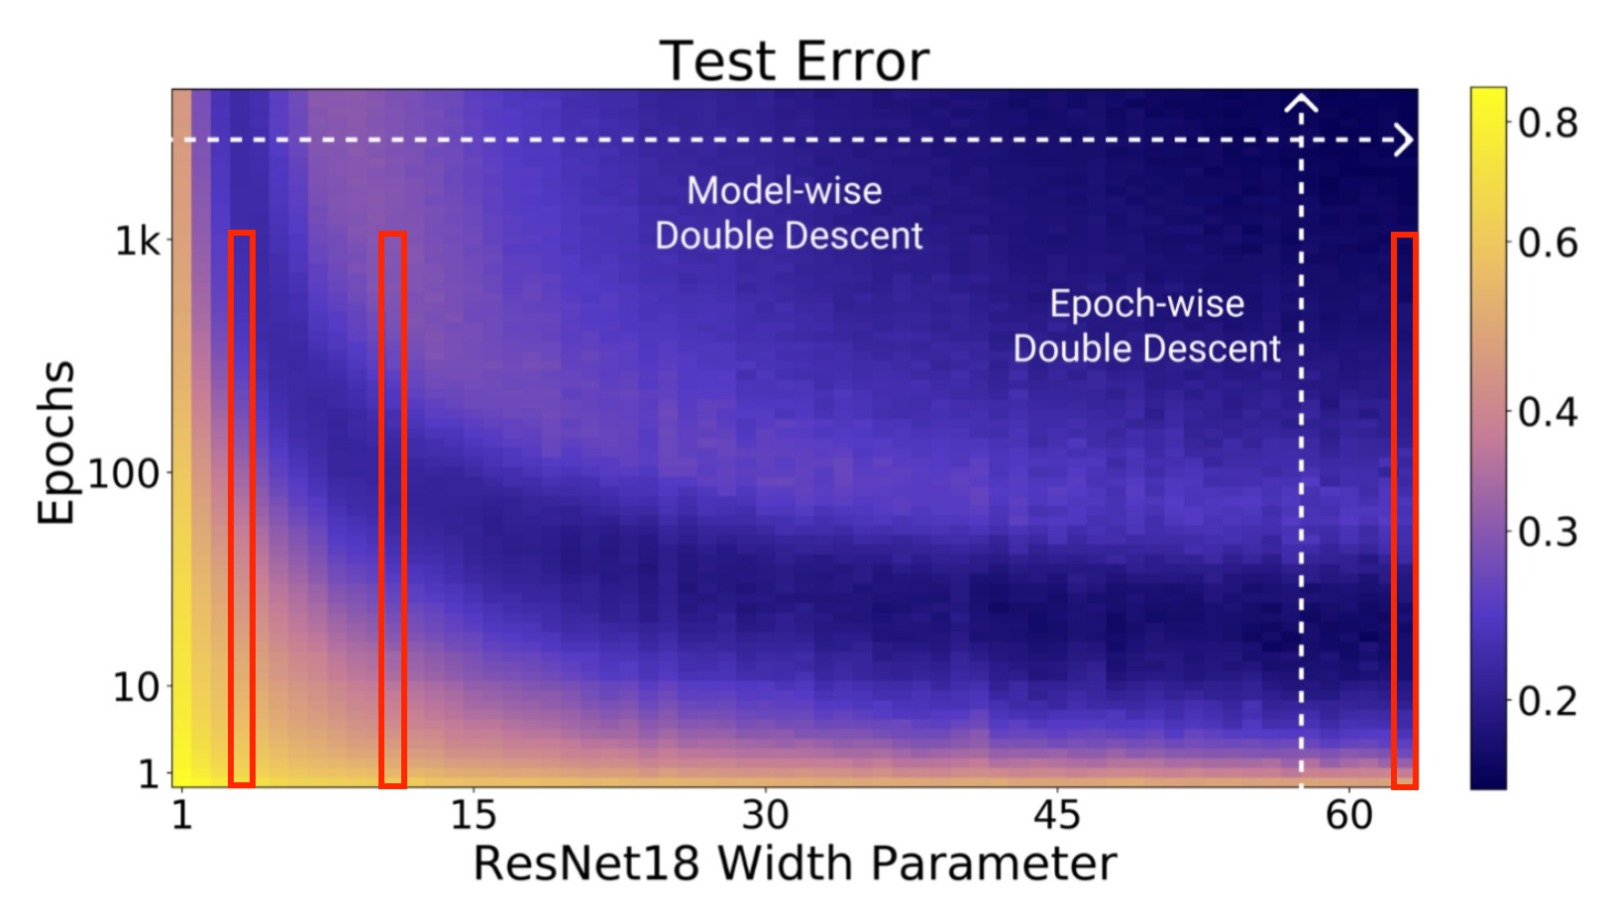

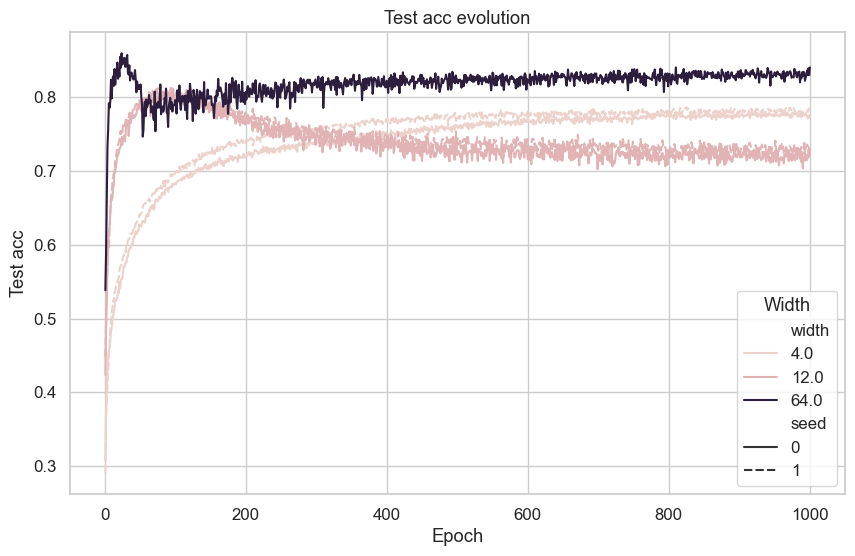

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\39763314.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


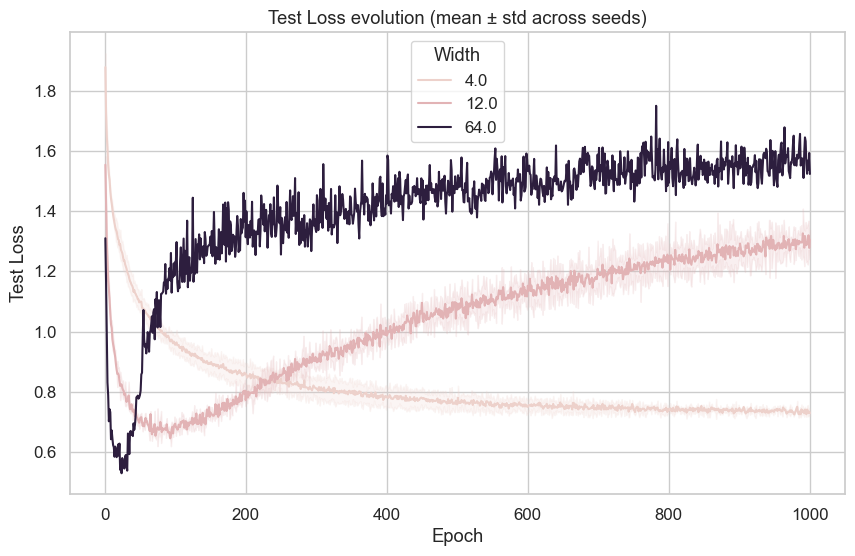

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_acc",
	hue="width", style="seed",
	estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_loss",
	hue="width",
	ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\458680810.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


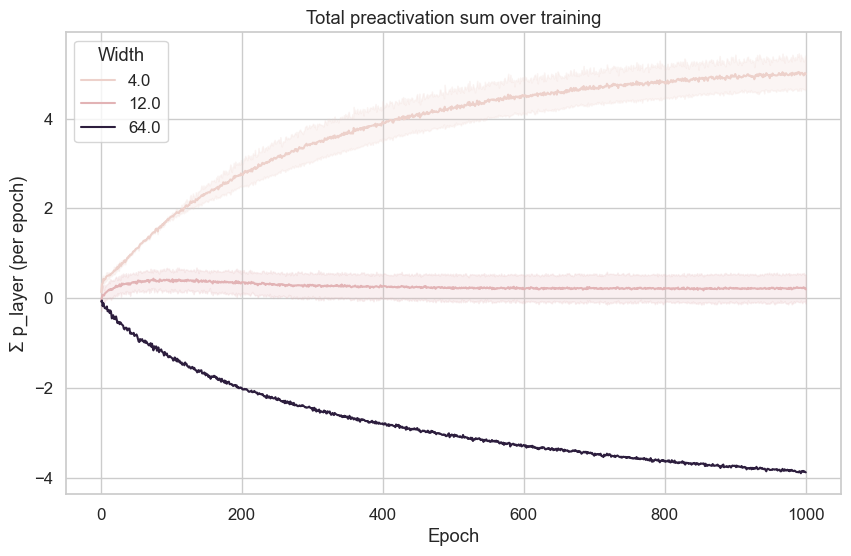

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="p_sum",
	hue="width",
	ci="sd"  # std deviation across seeds
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


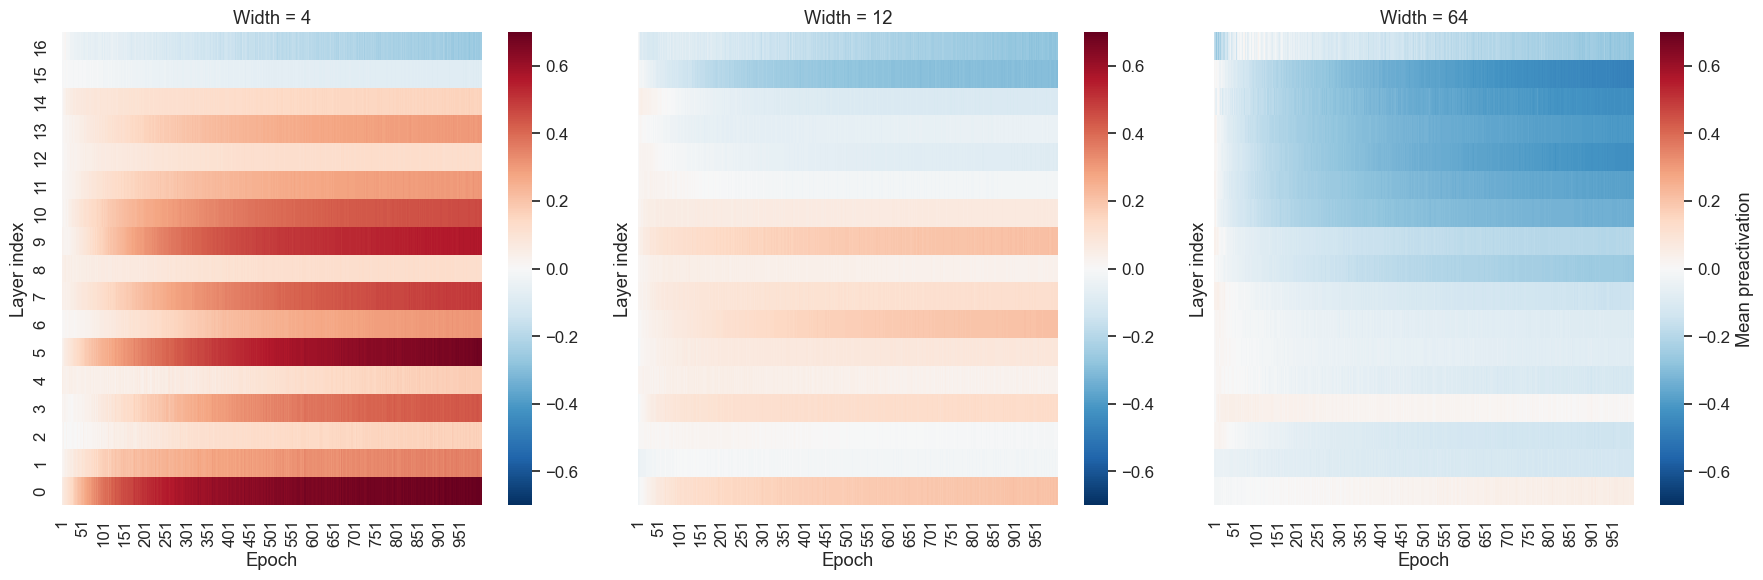

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs

# --- Load experiments ---
base = Path("results/2025-09-21_ResNet/default")

results = []
for csv in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv)
	logs = logs.assign(**meta)  # add metadata to each row
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# --- List of widths to plot ---
widths = [4, 12, 64]

# --- Prepare figure ---
fig, axes = plt.subplots(1, len(widths), figsize=(6 * len(widths), 6), sharey=True)

for ax, w in zip(axes, widths):
	df_w = df[df["width"] == w]

	p_layer_cols = [c for c in df_w.columns if c.startswith("p_layer")]
	df_long = df_w.melt(
		id_vars=["epoch", "seed"],
		value_vars=p_layer_cols,
		var_name="layer",
		value_name="p_value"
	)
	df_long["layer"] = df_long["layer"].str.replace("p_layer", "").astype(int)

	df_long_mean = (
		df_long.groupby(["layer", "epoch"], as_index=False)
		.agg(p_value=("p_value", "mean"))
	)

	pivot = df_long_mean.pivot(index="layer", columns="epoch", values="p_value")

	sns.heatmap(
		pivot,
		cmap="RdBu_r", center=0,
		vmin=-.7, vmax=.7,
		cbar_kws={"label": "Mean preactivation"} if ax == axes[-1] else None,
		xticklabels=50, ax=ax
	)
	ax.set_title(f"Width = {w}")
	ax.set_xlabel("Epoch")
	ax.set_ylabel("Layer index")
	ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs

base = Path("results/2025-09-22_CNN/default")

results = []
for csv in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv)
	logs = logs.assign(**meta)  # add metadata to each row
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert types
df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
	last_epoch.groupby(["arch", "width"])
	.agg(
		test_acc_mean=("test_acc", "mean"),
		test_acc_std=("test_acc", "std"),
		test_loss_mean=("test_loss", "mean"),
		test_loss_std=("test_loss", "std"),
		runs=("seed", "count"),
	)
	.reset_index()
)

# Print nicely
for _, row in agg.iterrows():
	print(
		f"{row.arch}, width={row.width:.3f}: "
		f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
		f"(n={row.runs}), "
		f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
	)


simplecnn, width=7.000: Acc=0.782 ± 0.003 (n=2), Loss=0.704 ± 0.000
simplecnn, width=20.000: Acc=0.768 ± 0.005 (n=2), Loss=0.721 ± 0.019
simplecnn, width=75.000: Acc=0.843 ± 0.010 (n=2), Loss=0.511 ± 0.036


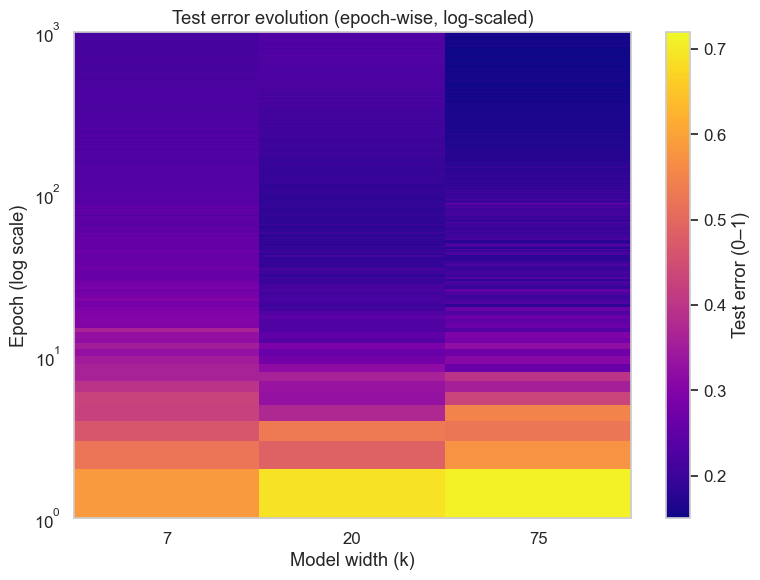

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
	df.groupby(["width", "epoch"], as_index=False)
	.agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [7, 20, 75]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values      # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [7, 20, 75]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.72)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

![WhatsApp Image 2025-10-03 at 13.34.58_d4d0a3bb.jpg](<attachment:WhatsApp Image 2025-10-03 at 13.34.58_d4d0a3bb.jpg>)
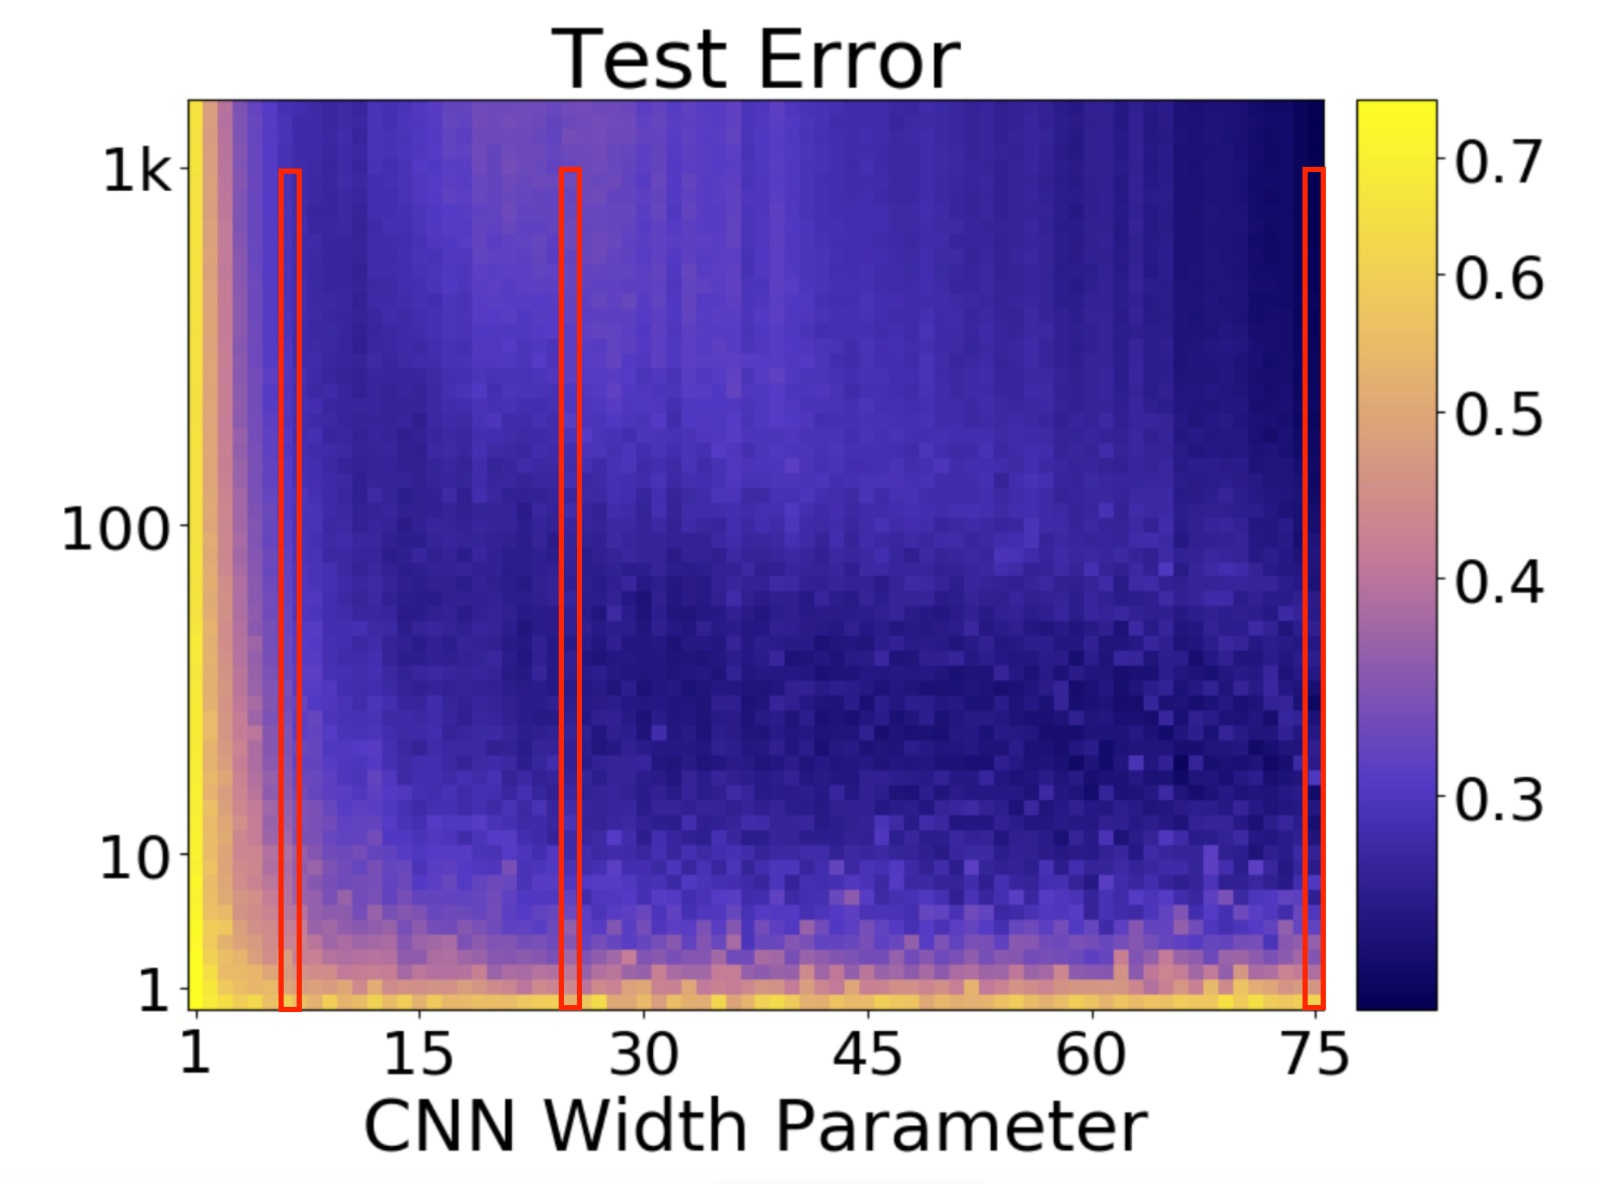

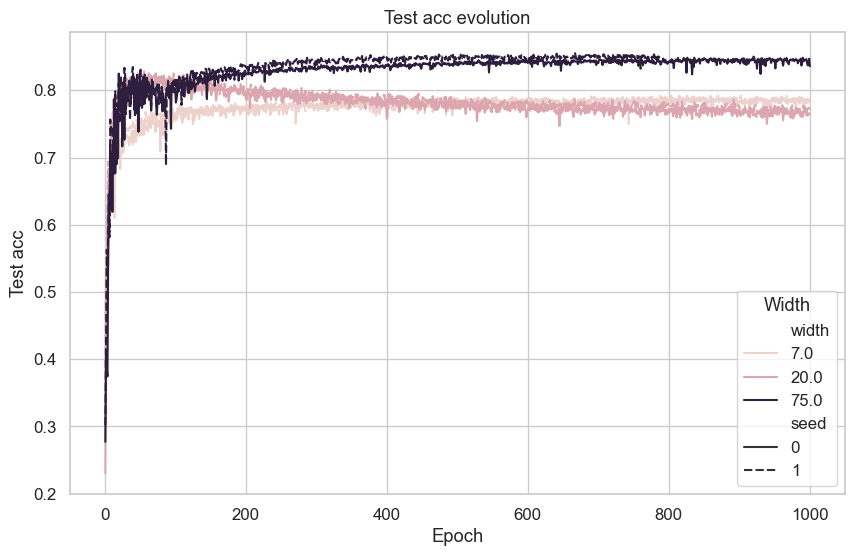

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\570724261.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


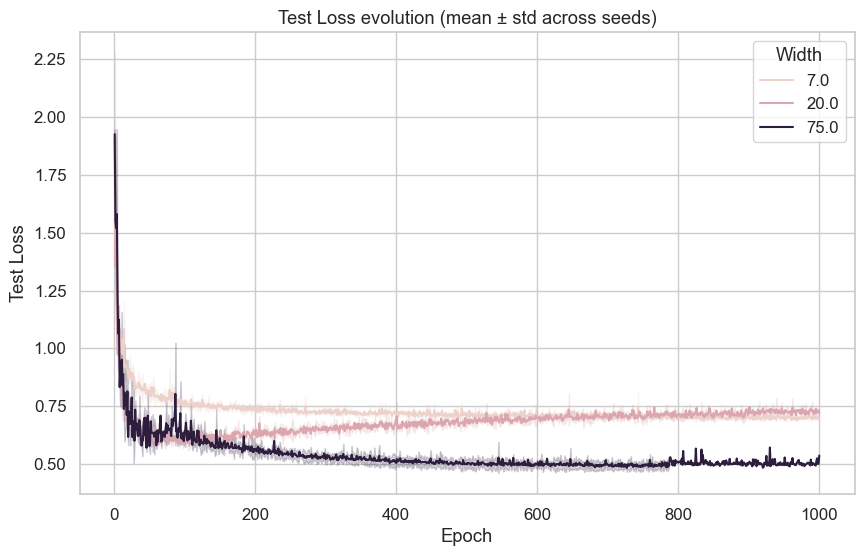

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: plot test loss for each width, each seed
plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_acc",
	hue="width", style="seed",
	estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_loss",
	hue="width",
	ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\458680810.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


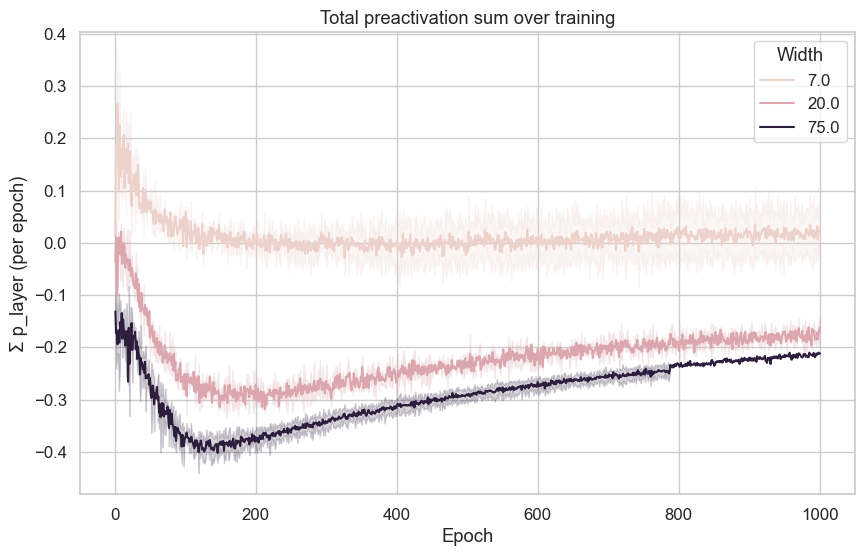

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="p_sum",
	hue="width",
	ci="sd"  # std deviation across seeds
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()


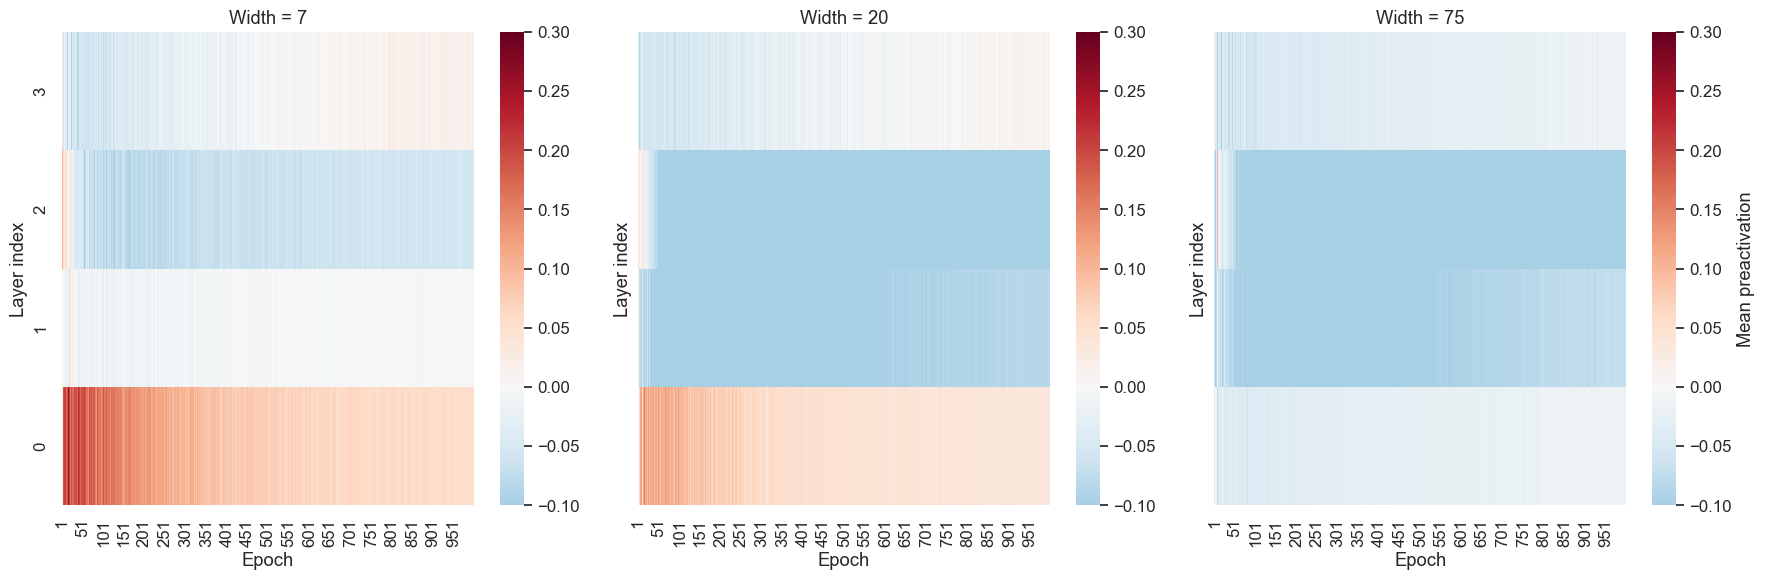

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs

# --- Load experiments ---
base = Path("results/2025-09-22_CNN/default")

results = []
for csv in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv)
	logs = logs.assign(**meta)  # add metadata to each row
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# --- List of widths to plot ---
widths = [7, 20, 75]

# --- Prepare figure ---
fig, axes = plt.subplots(1, len(widths), figsize=(6 * len(widths), 6), sharey=True)

for ax, w in zip(axes, widths):
	df_w = df[df["width"] == w]

	p_layer_cols = [c for c in df_w.columns if c.startswith("p_layer")]
	df_long = df_w.melt(
		id_vars=["epoch", "seed"],
		value_vars=p_layer_cols,
		var_name="layer",
		value_name="p_value"
	)
	df_long["layer"] = df_long["layer"].str.replace("p_layer", "").astype(int)

	df_long_mean = (
		df_long.groupby(["layer", "epoch"], as_index=False)
		.agg(p_value=("p_value", "mean"))
	)

	pivot = df_long_mean.pivot(index="layer", columns="epoch", values="p_value")

	sns.heatmap(
		pivot,
		cmap="RdBu_r", center=0,
		vmin=-.1, vmax=.3,
		cbar_kws={"label": "Mean preactivation"} if ax == axes[-1] else None,
		xticklabels=50, ax=ax
	)
	ax.set_title(f"Width = {w}")
	ax.set_xlabel("Epoch")
	ax.set_ylabel("Layer index")
	ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from pathlib import Path

def load_experiment_csv(path: Path):
	# read meta line
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs

base = Path("results/2025-10-09_Transformer/default")

results = []
for csv in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv)
	logs = logs.assign(**meta)  
	results.append(logs)

df = pd.concat(results, ignore_index=True)


df["width"] = df["width"].astype(float)
df["seed"] = df["seed"].astype(int)
df["noise"] = df["noise"].astype(float)
df["params"] = df["params"].astype(int)

# Take only the final epoch from each run
last_epoch = df.groupby(["arch", "width", "seed"]).tail(1)

# Aggregate over seeds
agg = (
	last_epoch.groupby(["arch", "width"])
	.agg(
		test_acc_mean=("test_acc", "mean"),
		test_acc_std=("test_acc", "std"),
		test_loss_mean=("test_loss", "mean"),
		test_loss_std=("test_loss", "std"),
		runs=("seed", "count"),
	)
	.reset_index()
)

# Print nicely
for _, row in agg.iterrows():
	print(
		f"{row.arch}, width={row.width:.3f}: "
		f"Acc={row.test_acc_mean:.3f} ± {row.test_acc_std:.3f} "
		f"(n={row.runs}), "
		f"Loss={row.test_loss_mean:.3f} ± {row.test_loss_std:.3f}"
	)


transformer, width=96.000: Acc=0.572 ± 0.002 (n=2), Loss=3.646 ± 0.016
transformer, width=200.000: Acc=0.558 ± 0.002 (n=2), Loss=4.080 ± 0.017
transformer, width=400.000: Acc=0.579 ± 0.000 (n=2), Loss=4.185 ± 0.022


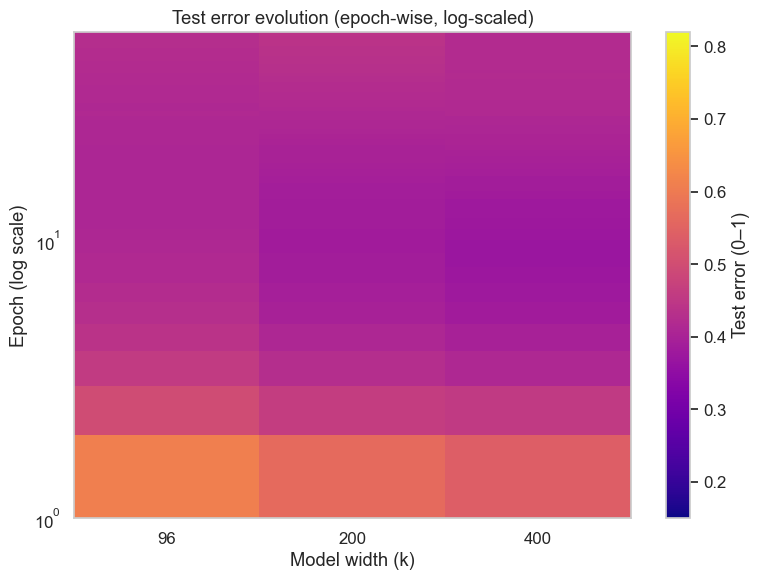

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Average across seeds, but compute error instead of accuracy
df_mean = (
	df.groupby(["width", "epoch"], as_index=False)
	.agg(test_error=("test_acc", lambda x: 1 - x.mean()))
)

# Pivot into width × epoch grid
pivot = df_mean.pivot(index="width", columns="epoch", values="test_error")

# If you only care about certain widths
selected_widths = [96,200,400]
pivot_sel = pivot.loc[selected_widths]

# pivot: rows = width, cols = epoch
Z = pivot_sel.T.values              # shape (n_epochs, n_widths)
epochs = pivot_sel.columns.values   # e.g. [1, 2, ..., 1000]
widths = [96,200,400]     # e.g. [0.0625, 0.2]

fig, ax = plt.subplots(figsize=(8, 6))

# define bin edges
X_edges = np.arange(len(widths) + 1)   # bin edges for widths
Y_edges = np.arange(epochs.min(), epochs.max() + 2)  # bin edges for epochs

X, Y = np.meshgrid(X_edges, Y_edges)

# fixed color scale from 0 to 1
c = ax.pcolormesh(X, Y, Z, cmap="plasma", shading="auto", vmin=0.15, vmax=0.82)

# log y-axis for epochs
ax.set_yscale("log")
ax.set_ylabel("Epoch (log scale)")
ax.set_xlabel("Model width (k)")

# ticks at bin centers
ax.set_xticks(np.arange(len(widths)) + 0.5)
ax.set_xticklabels(widths)

# colorbar
fig.colorbar(c, ax=ax, label="Test error (0–1)")
plt.title("Test error evolution (epoch-wise, log-scaled)")
plt.tight_layout()
plt.show()

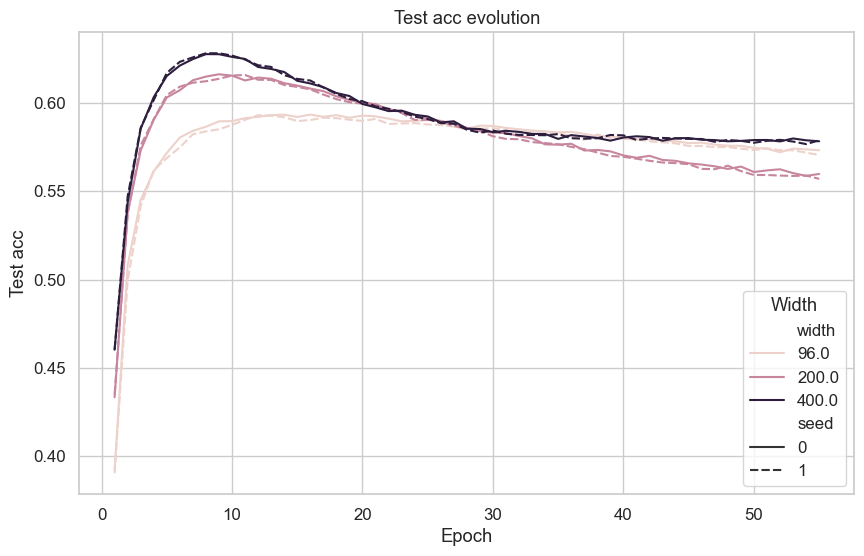

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\39763314.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


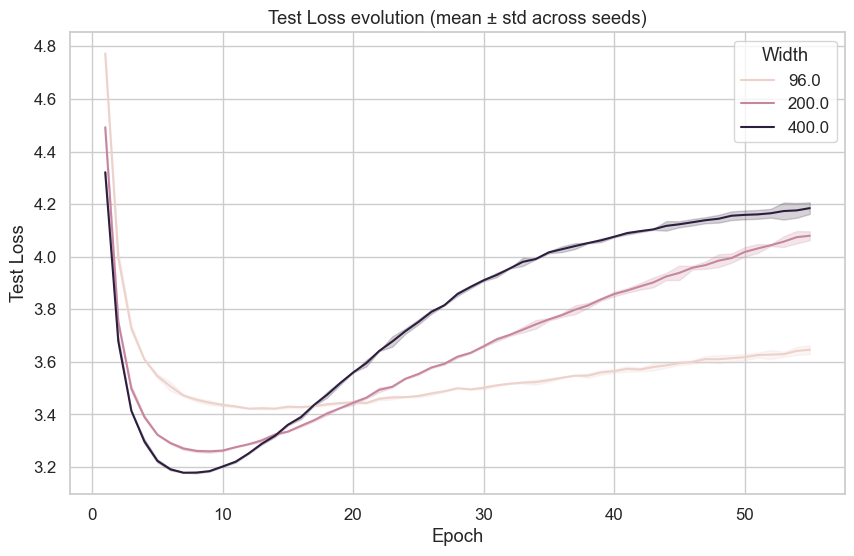

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_acc",
	hue="width", style="seed",
	estimator=None  # plot each seed separately
)
plt.title("Test acc evolution")
plt.ylabel("Test acc")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="test_loss",
	hue="width",
	ci="sd"  # shaded std deviation across seeds
)
plt.title("Test Loss evolution (mean ± std across seeds)")
plt.ylabel("Test Loss")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

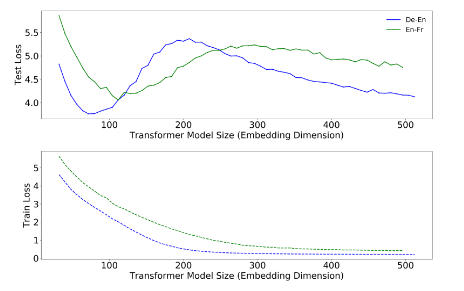

In [25]:
from IPython.display import Image
Image("images\image.png")


0      -2.967866
1      -9.664155
2     -12.324845
3     -13.664699
4     -13.551253
         ...    
325   -11.786030
326   -11.797817
327   -11.749189
328   -11.707863
329   -11.731066
Name: p_sum, Length: 330, dtype: float64


C:\Users\luord\AppData\Local\Temp\ipykernel_3368\3927449585.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


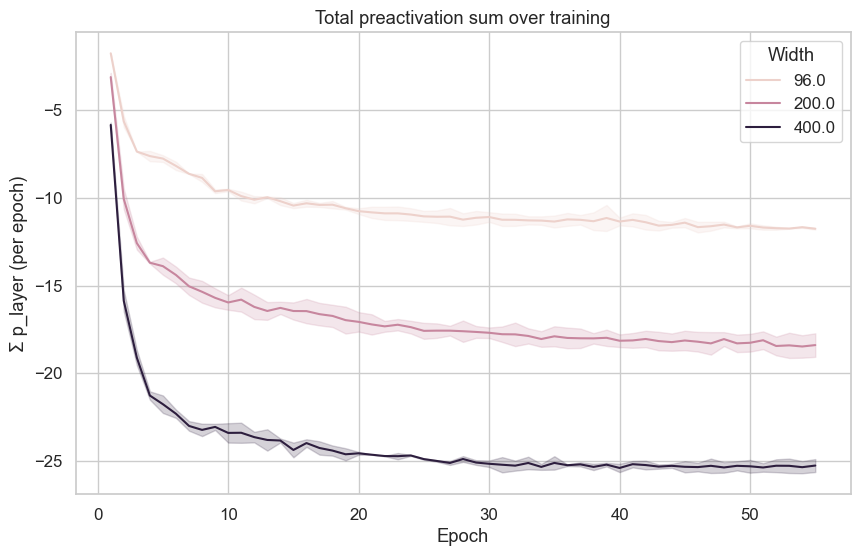

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

p_layer_cols = [c for c in df.columns if c.startswith("p_dec_layer")]
df["p_sum"] = df[p_layer_cols].sum(axis=1)
print(df["p_sum"])

plt.figure(figsize=(10,6))
sns.lineplot(
	data=df,
	x="epoch", y="p_sum",
	hue="width",
	ci="sd"  
)
plt.title("Total preactivation sum over training")
plt.ylabel("Σ p_layer (per epoch)")
plt.xlabel("Epoch")
plt.legend(title="Width")
plt.show()

C:\Users\luord\AppData\Local\Temp\ipykernel_3368\2939856377.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_long = df_long[df_long["layer"].str.contains(r"p_(enc|dec)")]
C:\Users\luord\AppData\Local\Temp\ipykernel_3368\2939856377.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_long = df_long[df_long["layer"].str.contains(r"p_(enc|dec)")]
C:\Users\luord\AppData\Local\Temp\ipykernel_3368\2939856377.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_long = df_long[df_long["layer"].str.contains(r"p_(enc|dec)")]


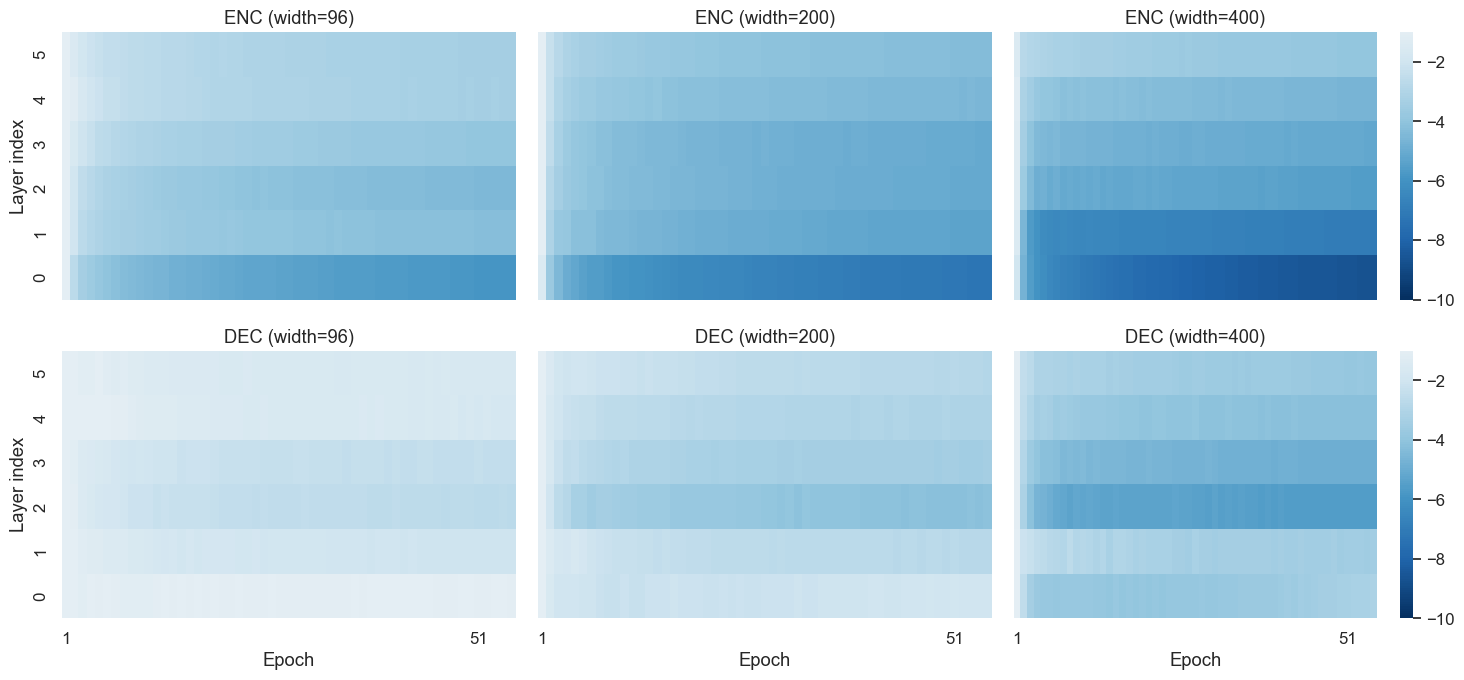

In [ ]:
import re

# --- Prepare figure ---
n_widths = len(widths)
layer_types = ["enc", "dec"]

fig, axes = plt.subplots(2, n_widths, figsize=(15, 7), sharey=True, sharex=True)

for col, w in enumerate(widths):
	df_w = df[df["width"] == w]

	p_layer_cols = [c for c in df_w.columns if c.startswith("p_")]

	df_long = df_w.melt(
		id_vars=["epoch", "seed"],
		value_vars=p_layer_cols,
		var_name="layer",
		value_name="p_value"
	)
	
	# Filter out any layer names that are not enc or dec layers
	df_long = df_long[df_long["layer"].str.contains(r"p_(enc|dec)")]
	df_long["layer_type"] = df_long["layer"].apply(lambda x: re.findall(r"p_(enc|dec)", x)[0])
	df_long["layer_idx"] = df_long["layer"].apply(lambda x: int(re.findall(r"layer(\d+)", x)[0]))

	df_long_mean = (
		df_long.groupby(["layer_type", "layer_idx", "epoch"], as_index=False)
		.agg(p_value=("p_value", "mean"))
	)

	for row, ltype in enumerate(layer_types):
		df_sub = df_long_mean[df_long_mean["layer_type"] == ltype]
		if df_sub.empty:
			continue
		pivot = df_sub.pivot(index="layer_idx", columns="epoch", values="p_value")

		sns.heatmap(
			pivot,
			cmap="RdBu_r",
			center=0,
			xticklabels=50,
			vmin=-10,
			vmax=-1,
			ax=axes[row, col],
			cbar=(col == n_widths - 1),  # show colorbar only on last column
		)

		axes[row, col].invert_yaxis()
		axes[row, col].set_xlabel("Epoch" if row == 1 else "")
		axes[row, col].set_ylabel("Layer index" if col == 0 else "")

		title = f"{ltype.upper()} (width={w})"
		axes[row, col].set_title(title)

plt.tight_layout()
plt.show()


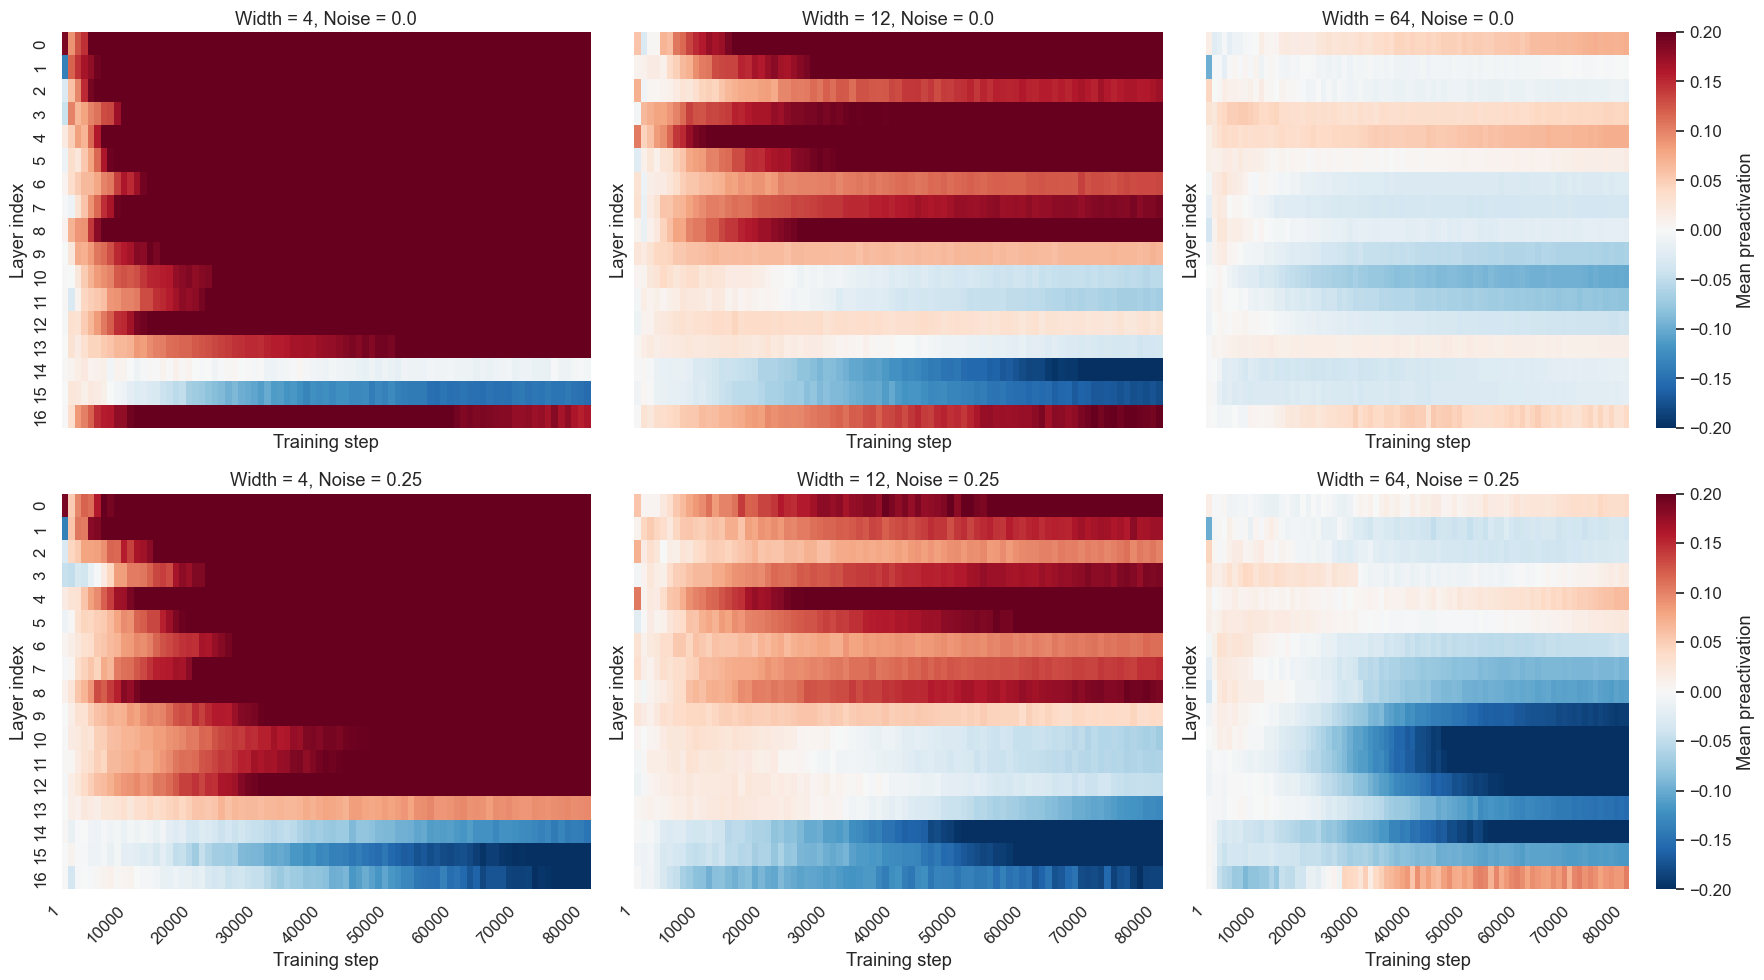

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# ---------------------------------------------------------
# Helper: load a metrics.csv file and extract metadata
# ---------------------------------------------------------
def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs


# ---------------------------------------------------------
# Load all experiment CSVs from a multirun directory
# ---------------------------------------------------------
base = Path("results/2025-10-30_BaseNet_NoWD/default")   # adjust path if needed
results = []

for csv_path in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv_path)
	logs = logs.assign(**meta)
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# ---------------------------------------------------------
# Choose widths and noise levels to visualize
# ---------------------------------------------------------
widths = sorted(df["width"].unique())
noise_levels = sorted(df["noise"].unique())

# ---------------------------------------------------------
# Plot setup
# ---------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(len(noise_levels), len(widths),
                         figsize=(6 * len(widths), 5 * len(noise_levels)),
                         sharex=True, sharey=True)

# make axes 2D even if single row/col
if len(noise_levels) == 1:
    axes = [axes]
if len(widths) == 1:
    axes = [[ax] for ax in axes]

# ---------------------------------------------------------
# Plot each noise × width combination
# ---------------------------------------------------------
for i, noise in enumerate(noise_levels):
    for j, w in enumerate(widths):
        ax = axes[i][j]
        df_sel = df[(df["width"] == w) & (df["noise"] == noise)]

        # Extract preactivation columns
        p_layer_cols = [c for c in df_sel.columns if c.startswith("p_layer")]

        # Melt to long form
        df_long = df_sel.melt(
            id_vars=["step", "seed"],
            value_vars=p_layer_cols,
            var_name="layer",
            value_name="p_value"
        )

        # Parse layer index
        df_long["layer"] = df_long["layer"].apply(lambda s: int(re.search(r"p_layer(\d+)", s).group(1)))

        # Average across seeds (per layer, step)
        df_mean = (
            df_long.groupby(["layer", "step"], as_index=False)
            .agg(p_value=("p_value", "mean"))
        )

        # Pivot → rows=layer, columns=step
        pivot = df_mean.pivot(index="layer", columns="step", values="p_value")
        pivot = pivot.sort_index(axis=0).sort_index(axis=1)

        # Plot
        sns.heatmap(
            pivot,
            ax=ax,
            cmap="RdBu_r",
            center=0,
            vmin=-0.2, vmax=0.2,
            xticklabels=False,  # we'll manually handle tick labels below
            yticklabels=True,
            cbar=(j == len(widths) - 1),
            cbar_kws={"label": "Mean preactivation"} if j == len(widths) - 1 else None
        )

        # Titles and labels
        ax.set_title(f"Width = {w}, Noise = {noise}")
        ax.set_xlabel("Training step")
        ax.set_ylabel("Layer index")

        # -------------------------------------------------
        # Fix x-axis ticks → show fewer (every ~10th step)
        # -------------------------------------------------
        steps = pivot.columns.to_numpy()
        num_steps = len(steps)
        tick_stride = max(1, num_steps // 8)   # show about 8 tick labels
        tick_idx = range(0, num_steps, tick_stride)

        ax.set_xticks(tick_idx)
        ax.set_xticklabels([int(steps[i]) for i in tick_idx], rotation=45, ha="right")

plt.tight_layout()
plt.show()


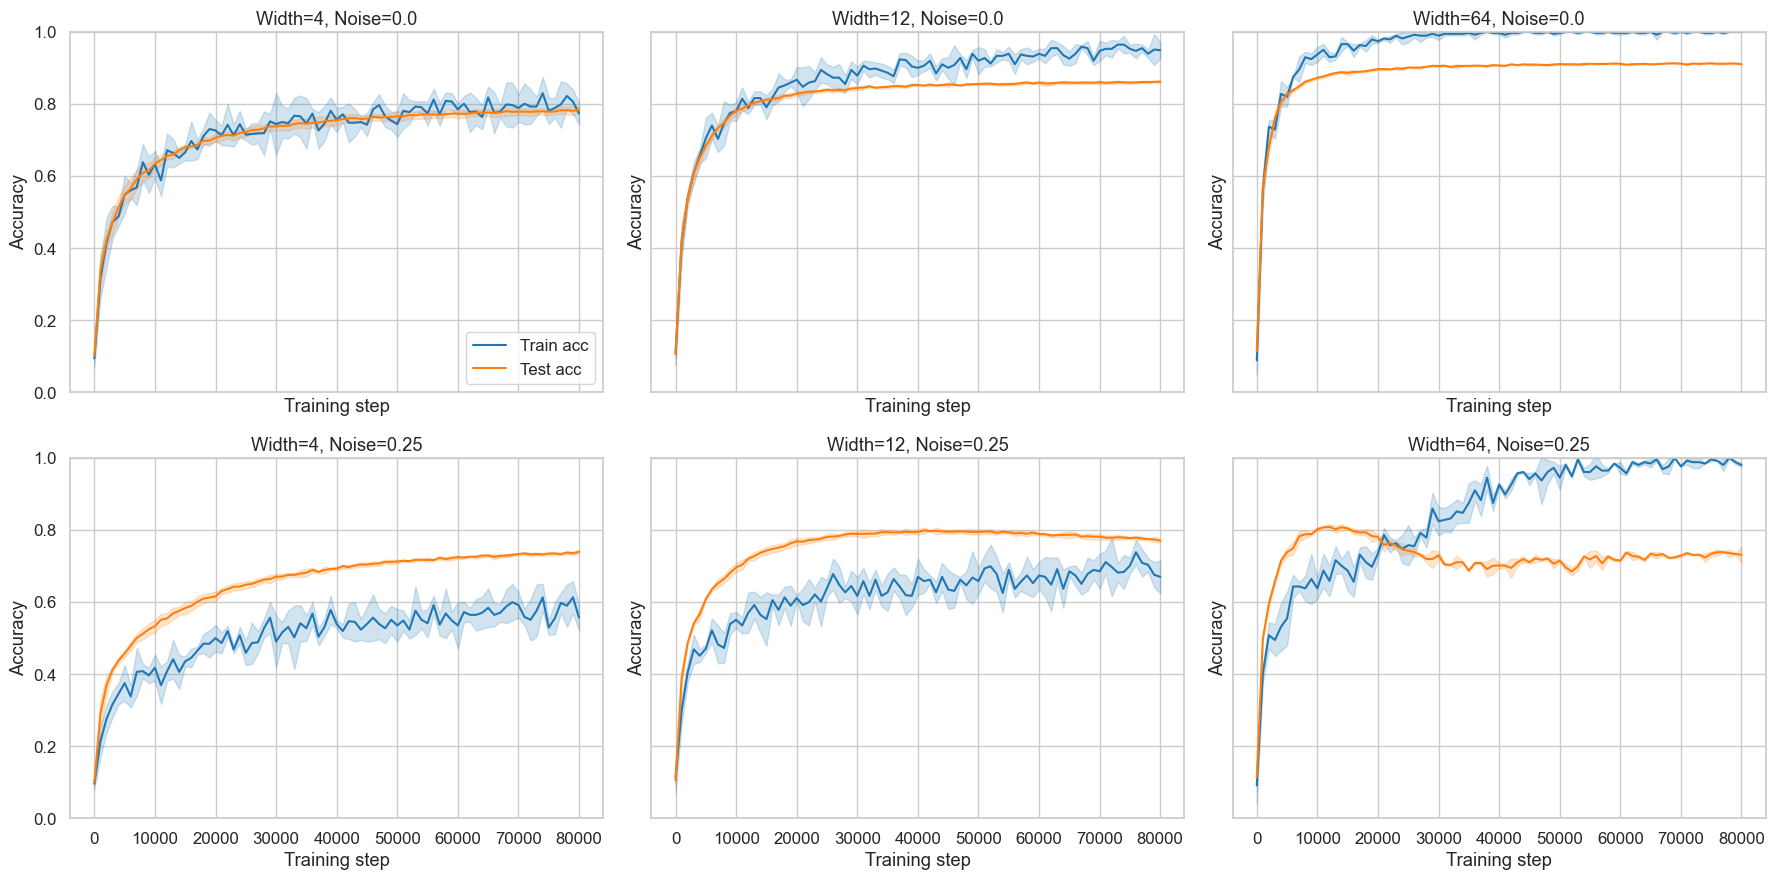

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------------------------------------------------
# Helper: load a metrics.csv file and extract metadata
# ---------------------------------------------------------
def load_experiment_csv(path: Path):
	with open(path, "r") as f:
		meta_header = f.readline().strip().split(",")
		meta_values = f.readline().strip().split(",")
	meta = dict(zip(meta_header, meta_values))
	logs = pd.read_csv(path, skiprows=2)
	return meta, logs


# ---------------------------------------------------------
# Load all experiment CSVs
# ---------------------------------------------------------
base = Path("results/2025-10-30_BaseNet_NoWD/default")  # adjust path if needed
results = []

for csv_path in base.rglob("metrics.csv"):
	meta, logs = load_experiment_csv(csv_path)
	logs = logs.assign(**meta)
	results.append(logs)

df = pd.concat(results, ignore_index=True)

# Convert metadata types
df["width"] = pd.to_numeric(df["width"], errors="coerce")
df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")
df["noise"] = pd.to_numeric(df["noise"], errors="coerce")
df["params"] = pd.to_numeric(df["params"], errors="coerce").astype("Int64")

# ---------------------------------------------------------
# Choose widths and noise levels to visualize
# ---------------------------------------------------------
widths = sorted(df["width"].unique())
noise_levels = sorted(df["noise"].unique())

# ---------------------------------------------------------
# Plot setup
# ---------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(len(noise_levels), len(widths),
						 figsize=(6 * len(widths), 4.5 * len(noise_levels)),
						 sharex=True, sharey=True)

if len(noise_levels) == 1:
	axes = [axes]
if len(widths) == 1:
	axes = [[ax] for ax in axes]

# ---------------------------------------------------------
# Plot each noise × width combination with std shading
# ---------------------------------------------------------
for i, noise in enumerate(noise_levels):
	for j, w in enumerate(widths):
		ax = axes[i][j]
		df_sel = df[(df["width"] == w) & (df["noise"] == noise)]

		# --- Aggregate across seeds: mean and std ---
		df_stats = (
			df_sel.groupby("step", as_index=False)
			.agg(
				train_acc_mean=("train_acc", "mean"),
				train_acc_std=("train_acc", "std"),
				test_acc_mean=("test_acc", "mean"),
				test_acc_std=("test_acc", "std"),
			)
		)

		# --- Plot mean curves ---
		ax.plot(df_stats["step"], df_stats["train_acc_mean"], color="tab:blue", label="Train acc")
		ax.plot(df_stats["step"], df_stats["test_acc_mean"], color="tab:orange", label="Test acc")

		# --- Shaded std deviation regions ---
		ax.fill_between(
			df_stats["step"],
			df_stats["train_acc_mean"] - df_stats["train_acc_std"],
			df_stats["train_acc_mean"] + df_stats["train_acc_std"],
			color="tab:blue", alpha=0.2
		)
		ax.fill_between(
			df_stats["step"],
			df_stats["test_acc_mean"] - df_stats["test_acc_std"],
			df_stats["test_acc_mean"] + df_stats["test_acc_std"],
			color="tab:orange", alpha=0.2
		)

		# --- Labels and titles ---
		ax.set_title(f"Width={w}, Noise={noise}")
		ax.set_xlabel("Training step")
		ax.set_ylabel("Accuracy")
		ax.set_ylim(0, 1)
		if i == 0 and j == 0:
			ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


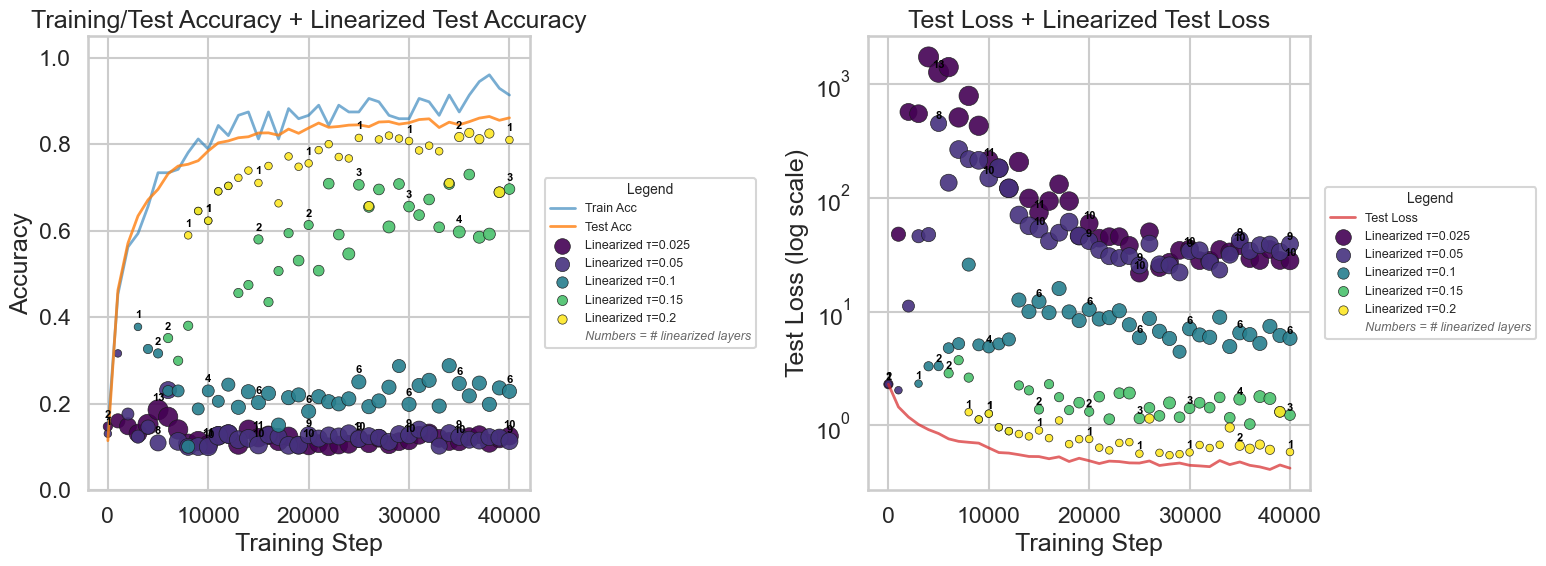

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_linearization_results(metrics_csv, linearization_csv, save_path=None, label_every=5000):
    """
    Two-panel visualization:
      • Left: Train/Test accuracy + linearized test accuracy (color-coded by τ)
      • Right: Test loss + linearized test loss (color-coded by τ)
    Annotates selected linearization points with #linear layers (next to dots),
    and puts legends outside the plot area (no shared colorbar).
    """
    # --- Load data ---
    df_metrics = pd.read_csv(metrics_csv, skiprows=2)
    df_lin = pd.read_csv(linearization_csv)

    # --- Normalize columns ---
    df_metrics.columns = [c.strip().lower() for c in df_metrics.columns]
    df_lin.columns = [c.strip().lower() for c in df_lin.columns]

    # --- Detect step column ---
    if "step" in df_metrics.columns:
        step_col = "step"
    elif "epoch" in df_metrics.columns:
        step_col = "epoch"
    else:
        step_col = df_metrics.columns[0]

    # --- Sort and setup ---
    df_lin = df_lin.sort_values(by=["index", "threshold"])
    taus = sorted(df_lin["threshold"].unique())

    sns.set(style="whitegrid", context="talk")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)
    ax_acc, ax_loss = axes

    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=min(taus), vmax=max(taus))

    # Generate consistent colors per τ
    tau_colors = {tau: cmap(norm(tau)) for tau in taus}

    # ============================================================
    # LEFT PANEL – ACCURACY
    # ============================================================
    line1, = ax_acc.plot(df_metrics[step_col], df_metrics["train_acc"],
                         label="Train Acc", color="tab:blue", alpha=0.6, linewidth=2)
    line2, = ax_acc.plot(df_metrics[step_col], df_metrics["test_acc"],
                         label="Test Acc", color="tab:orange", alpha=0.8, linewidth=2)

    scatter_handles = []
    for tau in taus:
        sub = df_lin[df_lin["threshold"] == tau]
        color = tau_colors[tau]
        sizes = (sub["num_linear_layers"] + 1) * 15
        sc = ax_acc.scatter(sub["index"], sub["test_acc"], c=[color], s=sizes,
                            edgecolors="k", linewidths=0.5, alpha=0.9,
                            label=f"Linearized τ={tau:g}")
        scatter_handles.append(sc)

        # Annotate selectively
        for _, row in sub.iterrows():
            if (row["index"] % label_every == 0 or 
                row["index"] == sub["index"].min() or 
                row["index"] == sub["index"].max()):
                ax_acc.text(
                    row["index"], row["test_acc"] + 0.015,
                    f"{int(row['num_linear_layers'])}",
                    fontsize=8, color="black", ha="center", va="bottom", weight="bold"
                )

    ax_acc.set_xlabel("Training Step")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.set_ylim(0, 1.05)
    ax_acc.set_title("Training/Test Accuracy + Linearized Test Accuracy")

    # --- Legend outside ---
    legend_elems = [line1, line2] + scatter_handles + [
        Line2D([], [], color="none", label="Numbers = # linearized layers")
    ]
    legend_labels = [h.get_label() for h in legend_elems]

    leg = ax_acc.legend(
        legend_elems, legend_labels,
        fontsize=9, frameon=True, loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        title="Legend", title_fontsize=10
    )
    leg.get_texts()[-1].set_color("dimgray")
    leg.get_texts()[-1].set_style("italic")

    # ============================================================
    # RIGHT PANEL – LOSS
    # ============================================================
    line3, = ax_loss.plot(df_metrics[step_col], df_metrics["test_loss"],
                          label="Test Loss", color="tab:red", alpha=0.7, linewidth=2)

    scatter_handles_loss = []
    if "test_loss" in df_lin.columns:
        for tau in taus:
            sub = df_lin[df_lin["threshold"] == tau]
            color = tau_colors[tau]
            sizes = (sub["num_linear_layers"] + 1) * 15
            sc = ax_loss.scatter(sub["index"], sub["test_loss"], c=[color], s=sizes,
                                 edgecolors="k", linewidths=0.5, alpha=0.9,
                                 label=f"Linearized τ={tau:g}")
            scatter_handles_loss.append(sc)

            # Annotate selectively
            for _, row in sub.iterrows():
                if (row["index"] % label_every == 0 or 
                    row["index"] == sub["index"].min() or 
                    row["index"] == sub["index"].max()):
                    ax_loss.text(
                        row["index"], row["test_loss"] * 1.05,
                        f"{int(row['num_linear_layers'])}",
                        fontsize=8, color="black", ha="center", va="bottom", weight="bold"
                    )
    else:
        print("⚠️ 'test_loss' column missing in linearization_results.csv — showing only test_loss from training.")

    ax_loss.set_xlabel("Training Step")
    ax_loss.set_ylabel("Test Loss (log scale)")
    ax_loss.set_yscale("log")
    ax_loss.set_title("Test Loss + Linearized Test Loss")

    # --- Legend outside (same format as accuracy) ---
    legend_elems_loss = [line3] + scatter_handles_loss + [
        Line2D([], [], color="none", label="Numbers = # linearized layers")
    ]
    legend_labels_loss = [h.get_label() for h in legend_elems_loss]

    leg2 = ax_loss.legend(
        legend_elems_loss, legend_labels_loss,
        fontsize=9, frameon=True, loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        title="Legend", title_fontsize=10
    )
    leg2.get_texts()[-1].set_color("dimgray")
    leg2.get_texts()[-1].set_style("italic")

    # --- Layout ---
    plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave room for outside legends
    if save_path:
        plt.savefig(save_path, dpi=250, bbox_inches="tight")
        print(f"✅ Saved plot to {save_path}")
    plt.show()

plot_linearization_results(
    metrics_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width12_seed0_noise0/metrics.csv",
    linearization_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width12_seed0_noise0/linearization_results.csv",
    save_path=None
)


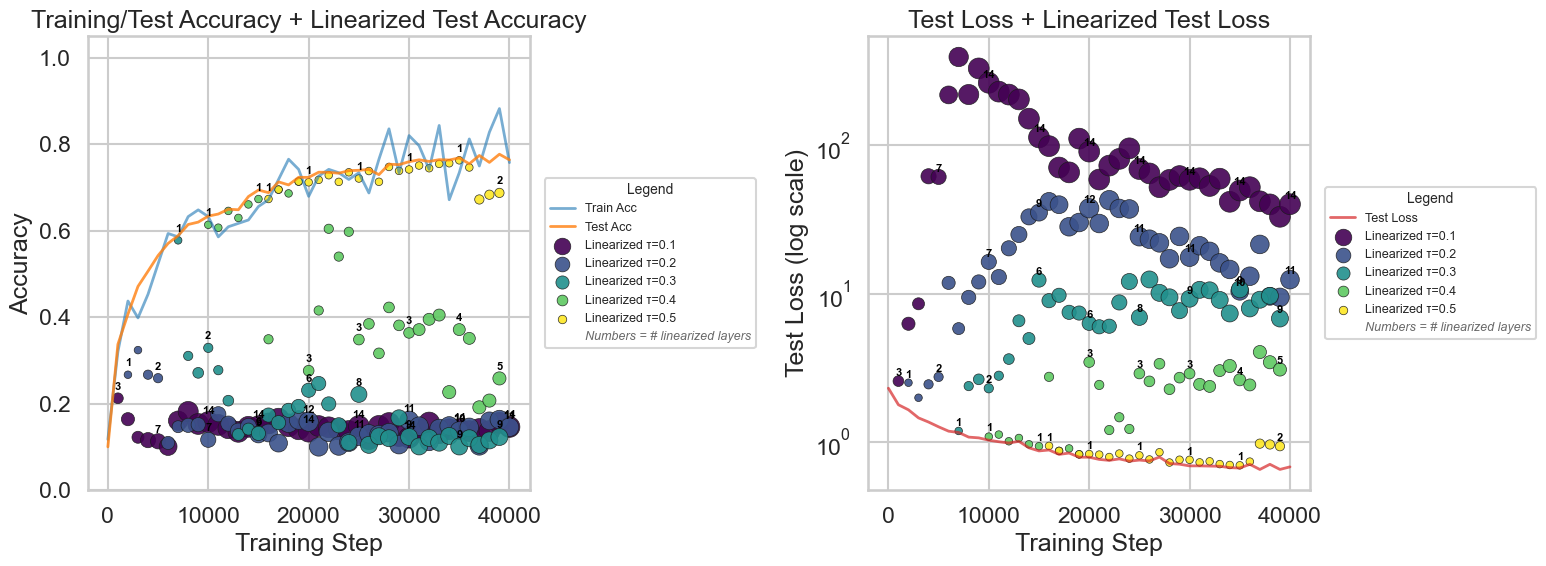

In [71]:
plot_linearization_results(
    metrics_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width4_seed0_noise0/metrics.csv",
    linearization_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width4_seed0_noise0/linearization_results.csv",
    save_path=None
)

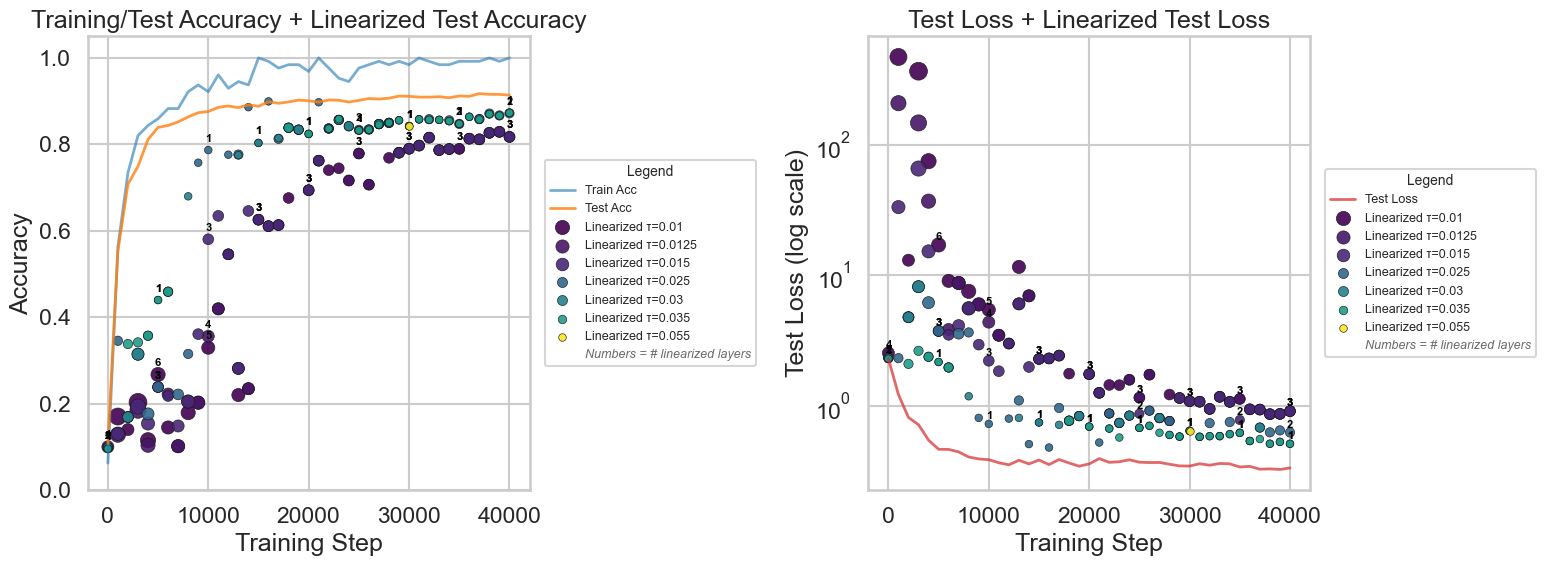

In [96]:
plot_linearization_results(
    metrics_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width64_seed0_noise0/metrics.csv",
    linearization_csv="results/BaseNet_w_checkpoints/2025-11-05_16-06-40/default/basenet18_width64_seed0_noise0/linearization_results.csv",
    save_path=None
)